## Análise  do discurso

--------------------------

Importação das bibliotecas

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
import nltk
import spacy 

# local libraries 
from tf_idf import get_tf_idf
import pre_processing as pre # pre processamento de dados
import data_visualization as plot # visualização dos dados
import data_visualization.colors as co # cores padrão para cada candidato

Leitura e armazenamento de transcrição - entrevistas

In [2]:
# leitura e armazenamento de dados em pandas Dataframe
folder = "interview_files"
instrucoes_path  = pd.read_csv("{}//{}".format(folder, "instruções.csv"))

arquivos = pre.get_files_tokens(folder, instrucoes_path) 

Limpeza/pré processamento de dados

In [3]:
arquivos = pre.process_tokens(arquivos)

Lemmatization & POS classification

In [4]:
nlp = spacy.load("pt_core_news_lg") #accuracy model

# criação coluna objto nlp()
arquivos['spacy_object'] = arquivos['tokens'].apply(lambda x: nlp(x))

# lemmatization
arquivos['lemma'] = arquivos['spacy_object'].apply(lambda x: x[0].lemma_)

# Part-Of-Speech tagging
arquivos['POS'] = arquivos['spacy_object'].apply(lambda x: x[0].pos_) 

arquivos['lemma'] = arquivos['lemma'].apply(lambda x: x.lower())
arquivos.drop('spacy_object', axis =1, inplace = True)

Stemming

In [5]:
rslp = nltk.stem.RSLPStemmer()

arquivos['stemming'] = arquivos['tokens'].apply(lambda x: rslp.stem(x))

Análise de Sentimentos 

    - Liwc2015_pt



In [6]:
# Importação e aplicação dicionário LIWC_2015_pt_br
liwc2015 = pre.read_liwc('LIWC2015 Dictionary - Brazilian Portuguese.dicx')

# atribuição da polaridade no df original 
arquivos = pd.merge(arquivos, liwc2015, on='lemma', how='left')
arquivos['score_liwc2015'].fillna(0, inplace=True)

**Seleção de entrevistas:**

- retirou-se a primeira entrevista após eleição do atual presidente - lula  
- retirou-se as entrevistas da rede_tv e valor_economico para totalizar 4 entrevistas por candidato
    - rede_tv teve apenas participação de bolsonaro
    - valor_economico - apenas participação de ciro e tebet

In [7]:
filtro_primeira_entrevista = (arquivos['evento'] != '30-10-22-primeiro_discurso_eleito_lula')

filtro_entrevistas_retiradas =  ((arquivos['evento'] != '09-22-rede_tv_setembro') &
                                 (arquivos['evento'] != '08-22-oglobo_valoreconomico_cbn'))

todas_entrevistas = arquivos.copy()

arquivos = arquivos[filtro_primeira_entrevista & filtro_entrevistas_retiradas].copy()

**TF-IDF**:  *the frequency of a term adjusted for how rarely it is used*

In [8]:
# TD-IDF por candidatos 
arquivos = get_tf_idf(df=arquivos, words_column='lemma', separation='candidato', new_column_name='tf_idf_candidato')

# TD-IDF por entrevistas(4) de cada candidato
arquivos = get_tf_idf(df=arquivos, words_column='lemma', separation='candidato', new_column_name='tf_idf_evento2', separation2= 'evento')

--------------------------

### Análises

In [9]:
# quantidade de tokens por candidato
arquivos[['candidato','tokens']].groupby("candidato").count()

,tokens
candidato,
bolsonaro,16833
ciro,15276
lula,18947
tebet,15150


In [10]:
# Criação de dataframes específicos para cada candidato
dfciro = arquivos[arquivos['candidato'] == 'ciro']
dftebet = arquivos[arquivos['candidato'] == 'tebet']
dfbolsonaro = arquivos[arquivos['candidato'] == 'bolsonaro']
dflula = arquivos[arquivos['candidato'] == 'lula']

Frequência de palavras 

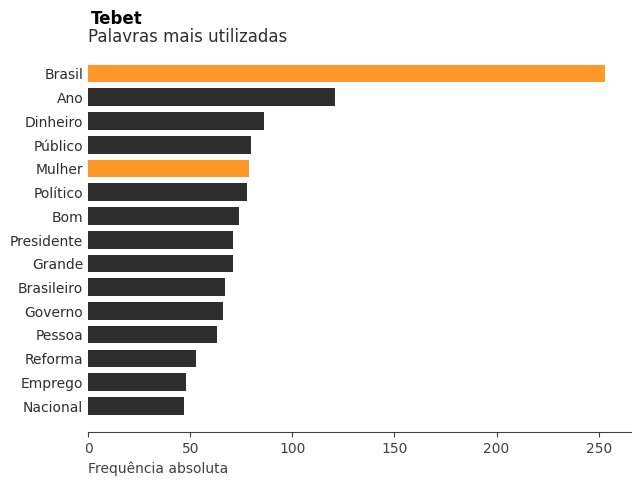

In [11]:
dfcandidato = dftebet

filtro_pos = ((dfcandidato['POS'] == 'NOUN') |
              (dfcandidato['POS'] == 'ADJ')  | 
              (dfcandidato['POS'] == 'PROPN'))

remove_words = ((dfcandidato['lemma'] != 'poder') & (dfcandidato['lemma'] != 'ver') & (dfcandidato['lemma'] != 'estar'))

dfcandidato = dfcandidato[(filtro_pos & remove_words)]


token_column = 'lemma'
lista_destaques = ['brasil', 'mulher']
plot.get_frequency(dfcandidato, token_column, lista_destaques, co.c_tebet1)

* quantificação de frequência de palavras

In [12]:
# frequência das palavras por candidato 

word_frequency = pd.pivot_table(arquivos, index='lemma', values= 'tokens', columns= 'candidato',aggfunc= 'count')
word_frequency.fillna(0, inplace=True)

pos_tagging = arquivos[['lemma','POS']].drop_duplicates('lemma').set_index('lemma')
word_frequency = pd.merge(word_frequency, pos_tagging, left_index=True, right_index=True)

# calculo das palavras que mais apareceram  nas entrevistas como um todo:
word_frequency['soma'] = word_frequency['bolsonaro'] + word_frequency['ciro'] + word_frequency['lula'] + word_frequency['tebet']
word_frequency = word_frequency.sort_values('soma', ascending=False)

# calculo da frequencia relativa
word_frequency['bolsonaro'] = word_frequency['bolsonaro']/word_frequency['bolsonaro'].sum()
word_frequency['lula'] = word_frequency['lula']/word_frequency['lula'].sum()
word_frequency['ciro'] = word_frequency['ciro']/word_frequency['ciro'].sum()
word_frequency['tebet'] = word_frequency['tebet']/word_frequency['tebet'].sum()

Correlação da frequência de palavras

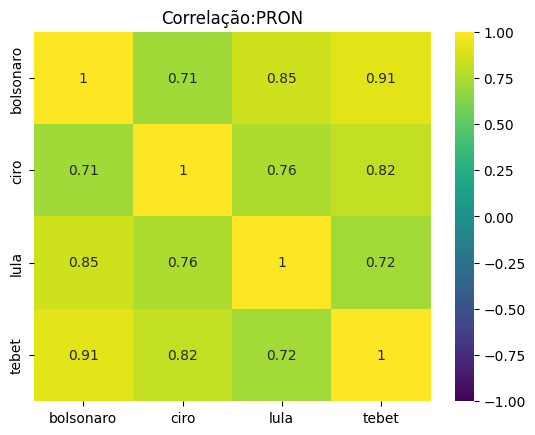

In [13]:
# seleção das palavras mais faladas 
word_frequency_m = word_frequency.drop('soma', axis=1)
pos1 = 'PRON'
filtro = (word_frequency_m['POS'] == pos1)

data = word_frequency_m[filtro]
n = 30
title = 'Correlação:{}'.format(pos1)

plot.get_cor(data, n, title)

* Comparação da utilização das palavras entre dois candidatos

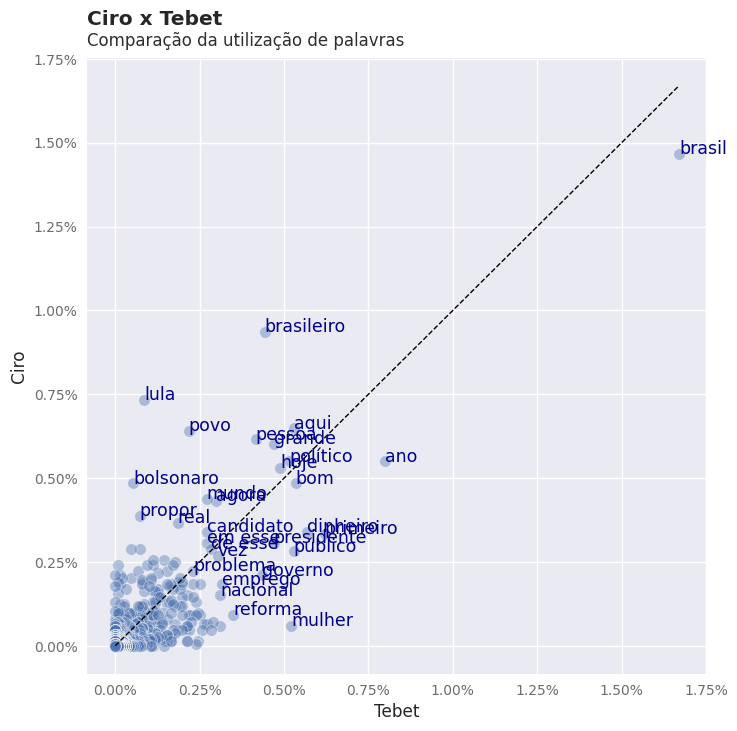

In [14]:
filtro_pos = ((word_frequency['POS'] == 'NOUN') |
            (word_frequency['POS'] == 'ADJ') | 
            (word_frequency['POS'] == 'PROPN') | 
            (word_frequency['POS'] =='ADV') |
            (word_frequency['POS'] == 'ADP'))

data = word_frequency[filtro_pos].copy()

col1 = 'tebet'
col2 = 'ciro'

plot.word_scatter(col1,col2, data)

Análise palavras mais importantes por candidato

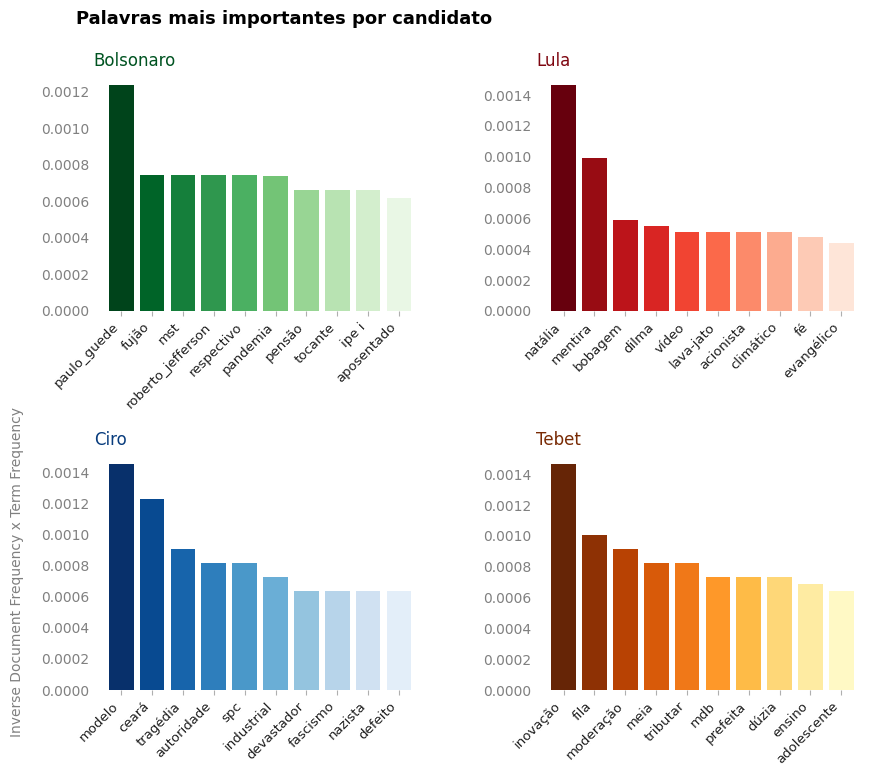

In [15]:
dfcandidato = arquivos
num_palavras = 10

filtro_pos = ((dfcandidato['POS'] == 'NOUN') |
              (dfcandidato['POS'] == 'ADJ') | 
              (dfcandidato['POS'] == 'PROPN'))

remove_words = ((dfcandidato['lemma'] != 'poder') & (dfcandidato['lemma'] != 'ver'))

dfcandidato = dfcandidato[(filtro_pos & remove_words)]

candidatos = ['bolsonaro', 'lula', 'ciro', 'tebet']

plot.highlight_important_words(dfcandidato, candidatos, num_palavras)

Análise das palavras mais importantes -  comparando por entrevistas do candidato

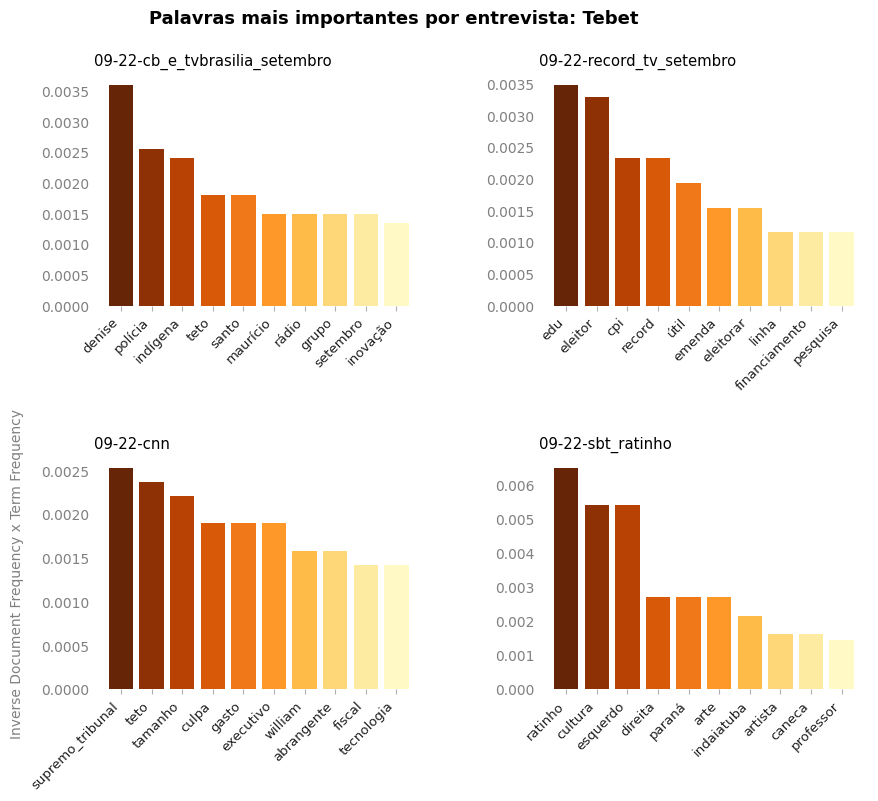

In [16]:
dfcandidato = dftebet

filtro_pos = ((dfcandidato['POS'] == 'NOUN') |
            (dfcandidato['POS'] == 'ADJ') | 
            (dfcandidato['POS'] == 'PROPN') | 
            (dfcandidato['POS'] =='ADV') |
            (dfcandidato['POS'] == 'ADP'))

dfcandidato = dfcandidato[filtro_pos]
color = 'YlOrBr'
num_palavras = 10

plot.highlight_words_interview(dfcandidato, color, num_palavras = 10) 

Nuvem de palavras

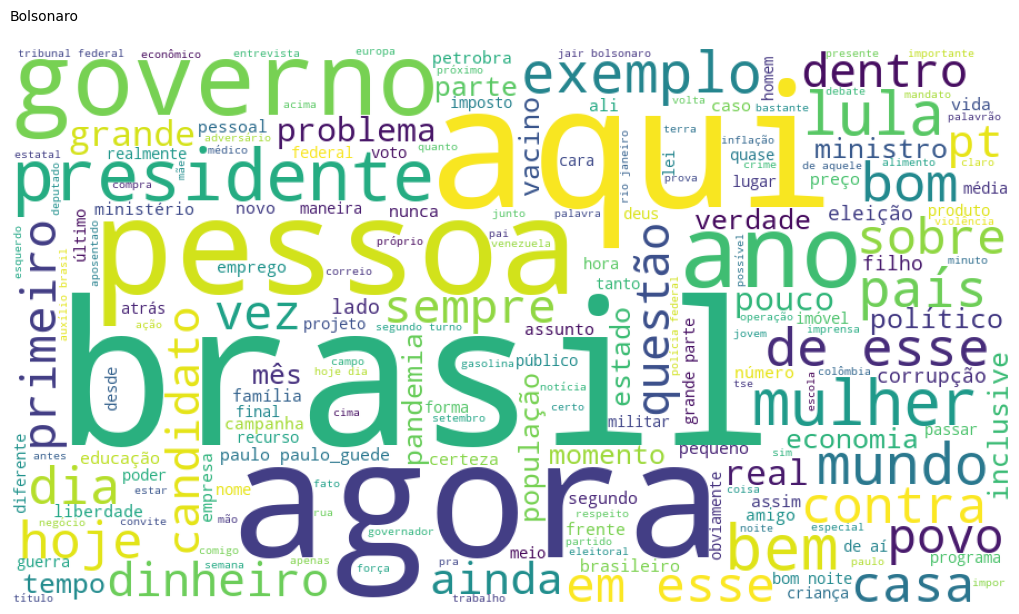

In [17]:
dfcandidato = dfbolsonaro

filtro_pos = ((dfcandidato['POS'] == 'NOUN') |
              (dfcandidato['POS'] == 'ADJ') | 
              (dfcandidato['POS'] == 'PROPN') | 
              (dfcandidato['POS'] == 'ADV') |
              (dfcandidato['POS'] == 'ADP'))

dfcandidato = dfcandidato[filtro_pos]

plot.get_wordcloud(dfcandidato)

Análise da polaridade por candidato

In [18]:
polarity_score = pd.pivot_table(data=arquivos, index= ['candidato'],values=['score_liwc2015'],aggfunc = 'mean')
polarity_score.round(4).sort_values('score_liwc2015', ascending=False)

,score_liwc2015
candidato,
lula,0.0329
tebet,0.0296
ciro,0.0221
bolsonaro,0.0204


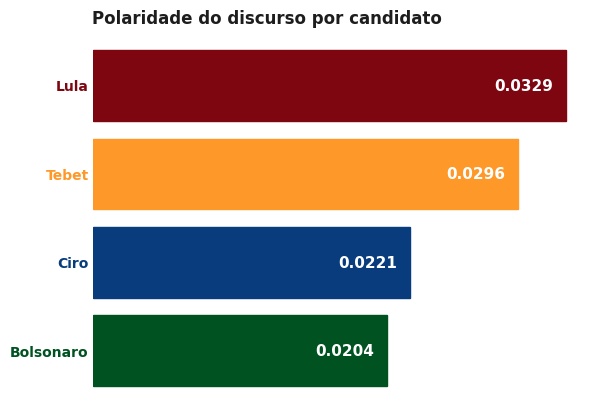

In [19]:
polarity_score = polarity_score.sort_values('score_liwc2015')
plot.polarity_score(polarity_score)

Análise da polaridade por entrevista

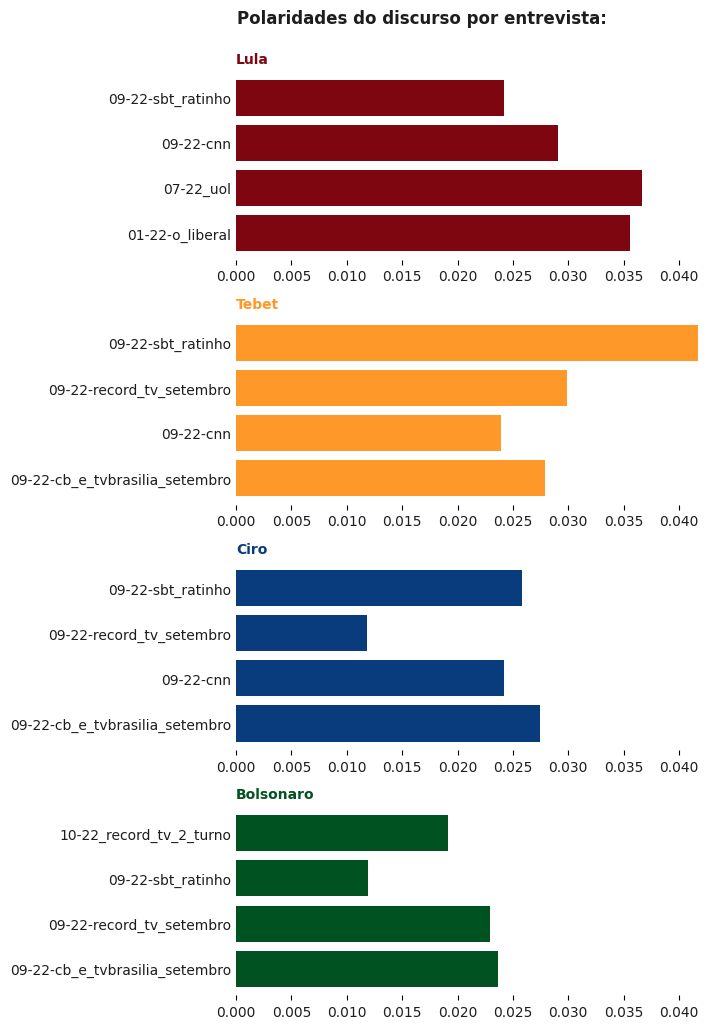

In [20]:
# polaridade dos discursos analisados por entrevista
interview_score_polarity = pd.pivot_table(data=arquivos, index= ['candidato','evento'],values=['score_liwc2015'],aggfunc = 'mean')
interview_score_polarity.reset_index(level=[0], drop=False, inplace=True)

fig, axes = plt.subplots(4,1,figsize=(6,12))

# [0] lula
candidato = 'lula'
color =  co.c_lula
plot.subplot_polarity(candidato,color, interview_score_polarity ,axes[0])

# [1] tebet 
candidato = 'tebet'
color = co.c_tebet1
plot.subplot_polarity(candidato, color, interview_score_polarity, axes[1])

# [2] ciro
candidato = 'ciro'
color = co.c_ciro
plot.subplot_polarity(candidato, color, interview_score_polarity ,axes[2])

# [3] bolsonaro
candidato = 'bolsonaro'
color = co.c_bolsonaro
plot.subplot_polarity(candidato,color, interview_score_polarity ,axes[3])

fig.suptitle('Polaridades do discurso por entrevista:', fontsize=12, va='baseline',fontweight='semibold',y=0.92, x=0.435, color=co.gray_9)

plt.subplots_adjust(wspace=.35, hspace=0.3)

plt.show()

In [21]:
# Quantidade de tokens classificados entre positivo, negativo e neutro por candidato 
pd.DataFrame(arquivos.groupby('candidato')['score_liwc2015'].value_counts())

count
candidato score_liwc2015       
bolsonaro  0.0            16011
           1.0              583
          -1.0              239
ciro       0.0            14479
           1.0              567
          -1.0              230
lula       0.0            17837
           1.0              867
          -1.0              243
tebet      0.0            14306
           1.0              646
          -1.0              198

Análise da polaridade ao longo de discurso único 

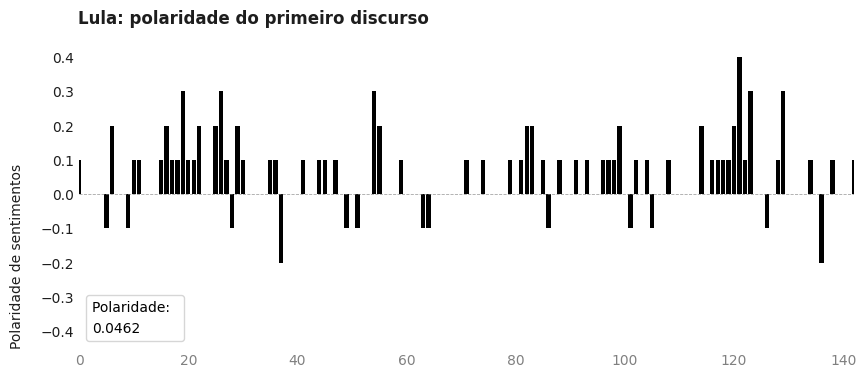

In [22]:
filtro_lula = (todas_entrevistas['evento'] == '30-10-22-primeiro_discurso_eleito_lula')
primeiro_discurso = todas_entrevistas[filtro_lula]

titulo = 'Lula: polaridade do primeiro discurso'
df_texto = primeiro_discurso

plot.text_polarity_trend(titulo, df_texto)

* Análise de categoria de termos por candidato

In [23]:
# Seleção de colunas relevantes para palavras que remetem opiniões
opinion_words = arquivos[['candidato','death', 'relig', 'money', 'work', 'ingest',
                          'health', 'family', 'sad', 'anger', 'anx', 'affect','lemma']].copy()

# frequência relativa dos termos 
count_opinion_words = opinion_words.groupby('candidato').count()
for i in count_opinion_words.columns:
    count_opinion_words[i] = count_opinion_words[i]/count_opinion_words['lemma']

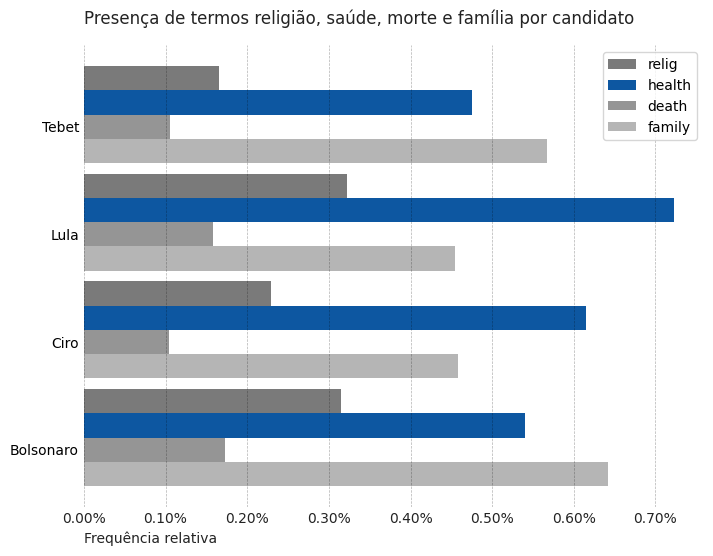

In [24]:
# Termos que remetem a 'religião', 'saúde', 'morte' e 'família'
multi = 2
count_opinion_words
titulo = 'Presença de termos religião, saúde, morte e família por candidato'
opinions = ['family','death', 'health', 'relig'] 
destaque = 'health'
plot.get_opinion(count_opinion_words, opinions, multi, titulo, destaque)

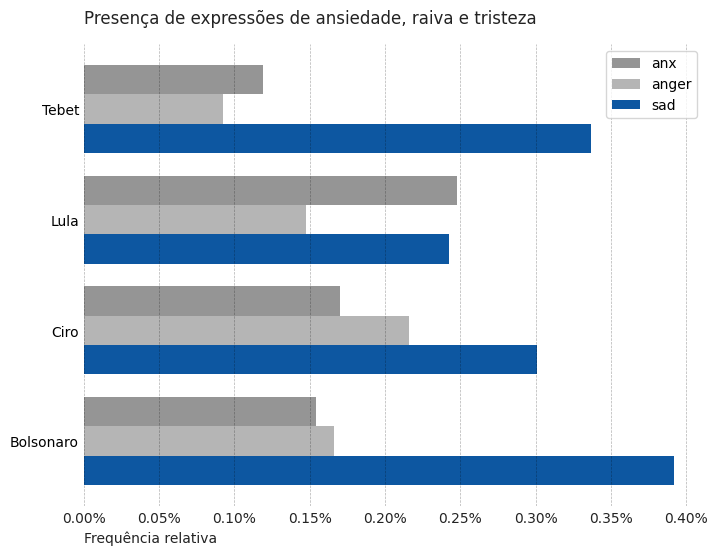

In [25]:
# Termos que remetem  'ansiedade', 'raiva' e 'tristeza'
multi = 1.7
count_opinion_words
titulo = 'Presença de expressões de ansiedade, raiva e tristeza'
opinions = ['sad', 'anger', 'anx'] 
destaque = 'sad'
plot.get_opinion(count_opinion_words, opinions, multi, titulo, destaque)